In [ ]:
import numpy as np
np.random.seed(42)

# ========== 参数设置 ==========
n_arms = 3           # 臂数量
n_features = 2        # 上下文特征维度
n_rounds = 5000       # 总轮次
alpha = 0.1           # 奖励噪声（已知）

# 初始化每个臂的 A 和 b
A = [np.eye(n_features) for _ in range(n_arms)]  # 初始 A = 单位矩阵（先验精度矩阵的逆）
b = [np.zeros(n_features) for _ in range(n_arms)]  # 初始 b = 0

# 生成真实参数（模拟数据）
w_true = np.random.randn(n_arms, n_features)  # 每个臂的真实权重

# ========== 函数定义 ==========
def generate_context():
    return np.random.rand(n_features)  # 生成上下文

def get_reward(context, arm):
    mean = np.dot(w_true[arm], context)
    return np.random.normal(mean, scale=alpha) # 生成奖励，加入噪声

# ========== Thompson Sampling 主循环 ==========
total_reward = 0

for t in range(n_rounds):
    context = generate_context()
    
    # 对每个臂，计算 μ 和 σ，并采样权重
    sampled_ws = []
    for arm in range(n_arms):
        A_inv = np.linalg.inv(A[arm])  # σ = A^{-1}
        mu = A_inv @ b[arm]            # μ = A^{-1} b
        sampled_w = np.random.multivariate_normal(mu, A_inv)
        sampled_ws.append(sampled_w)
    
    # 选择预测奖励最大的臂
    predicted_rewards = [np.dot(w, context) for w in sampled_ws]
    chosen_arm = np.argmax(predicted_rewards)
    
    # 获取奖励
    reward = get_reward(context, chosen_arm)
    total_reward += reward
    
    # 更新选中的臂的 A 和 b
    x = context.reshape(-1, 1)  # 转为列向量
    A[chosen_arm] += np.outer(x, x) / alpha  # A += x x^T / alpha
    b[chosen_arm] += x.flatten() * reward / alpha  # b += r x / alpha

# ========== 结果输出 ==========
print(f"Total Reward: {total_reward}")
print("True Weights:\n", w_true)
print("Learned Weights (A^{-1} b):")
for arm in range(n_arms):
    A_inv = np.linalg.inv(A[arm])
    mu = A_inv @ b[arm]
    print(f"Arm {arm}: {mu}")

Total Reward: 5427.451502603393
True Weights:
 [[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]]
Learned Weights (A^{-1} b):
Arm 0: [ 0.48974123 -0.14692257]
Arm 1: [0.63986859 1.52855886]
Arm 2: [-0.32714725 -0.06020964]


Round 100, Cumulative Reward: 51
Round 200, Cumulative Reward: 106
Round 300, Cumulative Reward: 174
Round 400, Cumulative Reward: 240
Round 500, Cumulative Reward: 303
Round 600, Cumulative Reward: 371
Round 700, Cumulative Reward: 432
Round 800, Cumulative Reward: 496
Round 900, Cumulative Reward: 565
Round 1000, Cumulative Reward: 634

=== 最终结果 ===
总奖励: 634 / 1000
真实权重:
 [[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]]
学习到的均值权重:
臂 0: [ 0.44665607 -0.74026487]
臂 1: [0.73775939 1.40768082]
臂 2: [-0.65686634 -0.51469995]


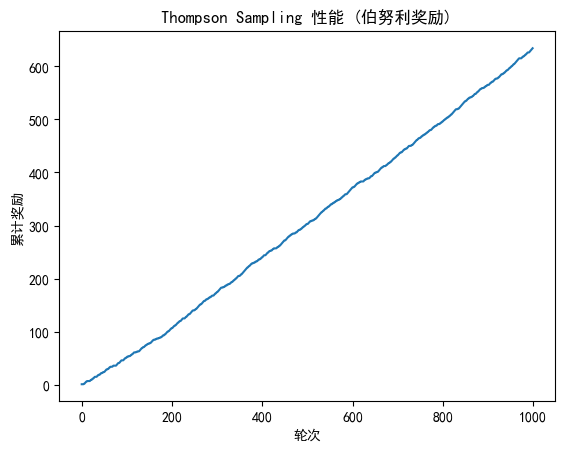

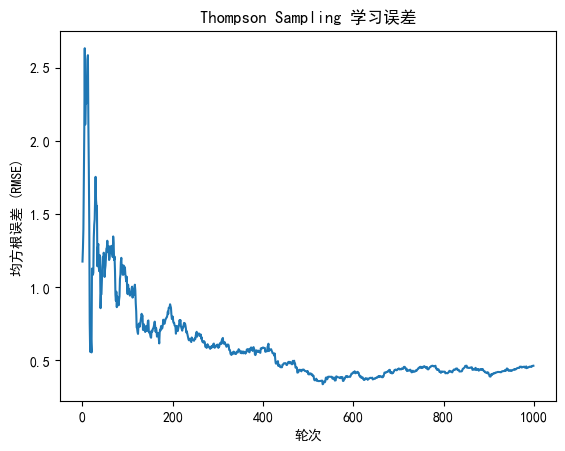

In [ ]:
import numpy as np
from scipy.optimize import minimize

# 设置随机种子（复现结果）
np.random.seed(42)

# ========== 参数设置 ==========
n_arms = 3            # 广告数量
n_features = 2         # 上下文特征维度（例如年龄、性别）
n_rounds = 1000         # 总轮次（减少计算量以加速示例）

# 初始化每个臂的后验参数（均值和协方差矩阵）
mu = np.zeros((n_arms, n_features))       # 均值初始化为0
sigma = [np.eye(n_features) * 10.0 for _ in range(n_arms)]  # 协方差初始化为较大值（高不确定性）

# 生成模拟数据（真实参数）
w_true = np.random.randn(n_arms, n_features)  # 每个臂的真实权重

# ========== 函数定义 ==========
def generate_context():
    """生成随机上下文（已标准化到[-1,1]范围）"""
    return np.random.uniform(-1, 1, size=n_features)

def sigmoid(x):
    """Logistic函数"""
    return 1 / (1 + np.exp(-x))

def get_reward(context, arm):
    """根据真实权重生成伯努利奖励"""
    logit = np.dot(w_true[arm], context)
    prob = sigmoid(logit)
    return int(np.random.rand() < prob)

def laplace_approximation(arm, context, reward, mu_prior, sigma_prior):
    """拉普拉斯近似更新后验分布"""
    # 定义负对数后验函数（需最小化）
    def neg_log_posterior(w):
        logit = np.dot(w, context)
        prob = sigmoid(logit)
        # 对数似然（伯努利）
        log_likelihood = reward * np.log(prob + 1e-10) + (1 - reward) * np.log(1 - prob + 1e-10)
        # 对数先验（高斯）
        log_prior = -0.5 * (w - mu_prior).T @ np.linalg.inv(sigma_prior) @ (w - mu_prior)
        return -(log_likelihood + log_prior)  # 负对数后验

    # 优化求解最大后验估计（MAP）
    result = minimize(neg_log_posterior, mu_prior, method='L-BFGS-B', 
                      options={'maxiter': 50, 'disp': False})
    if not result.success:
        print(f"Optimization failed for arm {arm}. Using prior mean.")
        w_map = mu_prior
    else:
        w_map = result.x

    # 计算Hessian矩阵（二阶导数）
    prob = sigmoid(np.dot(w_map, context))
    hessian = np.outer(context, context) * prob * (1 - prob) + np.linalg.inv(sigma_prior)

    # 返回近似后验的均值和协方差
    sigma_new = np.linalg.inv(hessian)
    return w_map, sigma_new

# ========== Thompson Sampling 主循环 ==========
total_reward = 0
rewards = []
errors = []

for t in range(n_rounds):
    context = generate_context()
    
    # 对每个臂，采样权重
    sampled_ws = []
    for arm in range(n_arms):
        # 从当前后验分布采样权重
        sampled_w = np.random.multivariate_normal(mu[arm], sigma[arm])
        sampled_ws.append(sampled_w)
    
    # 选择预测点击率最高的臂
    predicted_probs = [sigmoid(np.dot(w, context)) for w in sampled_ws]
    chosen_arm = np.argmax(predicted_probs)
    
    # 获取奖励（伯努利采样）
    reward = get_reward(context, chosen_arm)
    total_reward += reward
    rewards.append(reward)
    
    # 更新选中臂的后验分布（拉普拉斯近似）
    mu_prior = mu[chosen_arm].copy()
    sigma_prior = sigma[chosen_arm].copy()
    mu_new, sigma_new = laplace_approximation(
        chosen_arm, context, reward, mu_prior, sigma_prior
    )
    
    mu[chosen_arm] = mu_new
    sigma[chosen_arm] = sigma_new
    # 计算误差（真实权重与后验均值之间的均方根误差）
    rmse = np.sqrt(np.mean([np.linalg.norm(mu[arm] - w_true[arm])**2 for arm in range(n_arms)]))
    errors.append(rmse)

    # 打印进度
    if (t + 1) % 100 == 0:
        print(f"Round {t + 1}, Cumulative Reward: {total_reward}")

# ========== 结果输出 ==========
print("\n=== 最终结果 ===")
print(f"总奖励: {total_reward} / {n_rounds}")
print("真实权重:\n", w_true)
print("学习到的均值权重:")
for arm in range(n_arms):
    print(f"臂 {arm}: {mu[arm]}")

# 绘制累计奖励曲线
import matplotlib.pyplot as plt
# 中文显示设置（可选）
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

plt.plot(np.cumsum(rewards))
plt.xlabel("轮次")
plt.ylabel("累计奖励")
plt.title("Thompson Sampling 性能 (伯努利奖励)")
plt.show()
# 绘制误差曲线
plt.plot(errors)
plt.xlabel("轮次")
plt.ylabel("均方根误差 (RMSE)")
plt.title("Thompson Sampling 学习误差")
plt.show()

Round 100, Cumulative Reward: 71, RMSE: 0.468
Round 200, Cumulative Reward: 132, RMSE: 0.386
Round 300, Cumulative Reward: 199, RMSE: 0.397
Round 400, Cumulative Reward: 259, RMSE: 0.428
Round 500, Cumulative Reward: 322, RMSE: 0.425
Round 600, Cumulative Reward: 389, RMSE: 0.424
Round 700, Cumulative Reward: 454, RMSE: 0.419
Round 800, Cumulative Reward: 511, RMSE: 0.434
Round 900, Cumulative Reward: 574, RMSE: 0.409
Round 1000, Cumulative Reward: 635, RMSE: 0.398

=== 真实权重与后验均值对比 ===
真实权重:
 [[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]]
学习到的后验均值:
 [[ 0.34365585  0.15737409]
 [ 0.38032065  0.67051791]
 [-0.12251972 -0.06478963]]


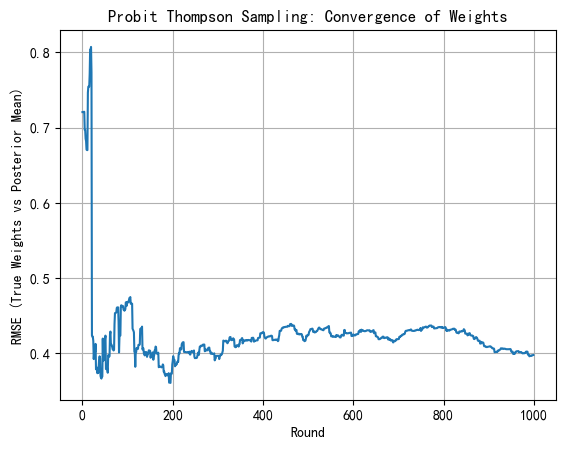

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# ========== 参数设置 ==========
n_arms = 3                   # 广告数量
n_features = 2               # 上下文特征维度
n_rounds = 1000              # 总轮次
v = 1.0                      # 先验协方差缩放因子

# 初始化每个臂的后验参数
mu = np.zeros((n_arms, n_features))          # 均值初始化为0
sigma = [v * np.eye(n_features) for _ in range(n_arms)]  # 协方差矩阵

# 生成真实权重（模拟数据）
w_true = np.random.randn(n_arms, n_features)  # 真实参数

# ========== 函数定义 ==========
def generate_context():
    """生成标准化上下文（-1到1均匀分布）"""
    return np.random.uniform(-1, 1, size=n_features)

def get_reward(context, arm):
    """基于Probit模型生成二进制奖励"""
    z_latent = np.dot(w_true[arm], context) + np.random.normal(0, 1)  # 潜在变量 z = w^T x + ε
    return 1 if z_latent > 0 else 0

def update_posterior(arm, context, reward):
    """更新后验分布（数据增广方法）"""
    # 采样潜在变量 z（截断正态分布）
    mu_current = np.dot(mu[arm], context)
    if reward == 1:
        z = np.random.normal(loc=mu_current, scale=1.0)
        z = max(z, 0)  # z > 0
    else:
        z = np.random.normal(loc=mu_current, scale=1.0)
        z = min(z, 0)  # z ≤ 0
    
    # 转换为线性高斯模型的观测值
    x = context.reshape(-1, 1)  # 转为列向量 (d,1)
    sigma_inv = np.linalg.inv(sigma[arm])
    
    # 更新协方差和均值
    sigma_new = np.linalg.inv(sigma_inv + np.outer(x, x))  # Σ_new = (Σ^{-1} + x x^T)^{-1}
    mu_new = sigma_new @ (sigma_inv @ mu[arm] + x.flatten() * z) # μ_new = (Σ^{-1} μ + x z) Σ_new
    
    return mu_new, sigma_new

# ========== Thompson Sampling 主循环 ==========
total_reward = 0
rmse_history = []  # 存储每一轮的RMSE

for t in range(n_rounds):
    context = generate_context()
    
    # 对每个臂采样权重
    sampled_ws = []
    for arm in range(n_arms):
        sampled_w = np.random.multivariate_normal(mu[arm], sigma[arm])
        sampled_ws.append(sampled_w)
    
    # 选择预测值最大的臂（基于潜在变量 z）
    predicted_z = [np.dot(w, context) for w in sampled_ws]
    chosen_arm = np.argmax(predicted_z)
    
    # 获取奖励
    reward = get_reward(context, chosen_arm)
    total_reward += reward
    
    # 更新后验分布
    mu_new, sigma_new = update_posterior(chosen_arm, context, reward)
    mu[chosen_arm] = mu_new
    sigma[chosen_arm] = sigma_new
    
    # 计算当前所有臂的RMSE
    current_rmse = np.sqrt(np.mean((mu - w_true)**2))
    rmse_history.append(current_rmse)
    
    # 打印进度
    if (t + 1) % 100 == 0:
        print(f"Round {t + 1}, Cumulative Reward: {total_reward}, RMSE: {current_rmse:.3f}")

# ========== 结果输出 ==========
print("\n=== 真实权重与后验均值对比 ===")
print("真实权重:\n", w_true)
print("学习到的后验均值:\n", mu)

# 绘制RMSE曲线
plt.plot(rmse_history)
plt.xlabel("Round")
plt.ylabel("RMSE (True Weights vs Posterior Mean)")
plt.title("Probit Thompson Sampling: Convergence of Weights")
plt.grid(True)
plt.show()

Round 100, Reward: 71, RMSE: 0.468
Round 200, Reward: 132, RMSE: 0.386
Round 300, Reward: 199, RMSE: 0.397
Round 400, Reward: 259, RMSE: 0.428
Round 500, Reward: 322, RMSE: 0.425
Round 600, Reward: 389, RMSE: 0.424
Round 700, Reward: 454, RMSE: 0.419
Round 800, Reward: 511, RMSE: 0.434
Round 900, Reward: 574, RMSE: 0.409
Round 1000, Reward: 635, RMSE: 0.398

=== 真实权重与后验均值对比 ===
真实权重:
 [[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]]
学习到的后验均值（A⁻¹b）:
臂 0: [0.34365585 0.15737409]
臂 1: [0.38032065 0.67051791]
臂 2: [-0.12251972 -0.06478963]


d:\anaconda3\envs\py310_torch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda3\envs\py310_torch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 185 (\N{SUPERSCRIPT ONE}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


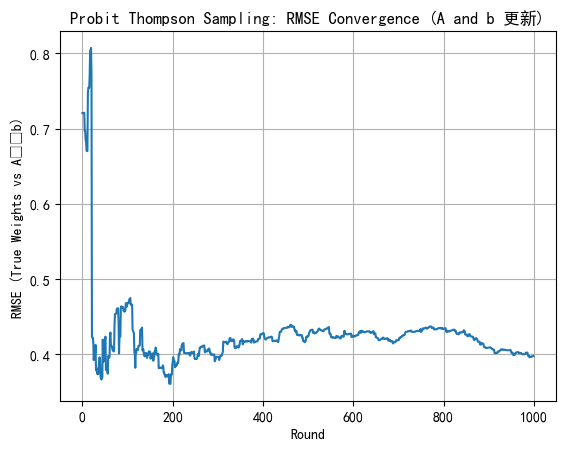

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# ========== 参数设置 ==========
n_arms = 3                   # 广告数量
n_features = 2               # 上下文特征维度
n_rounds = 1000              # 总轮次
v = 1.0                      # 先验协方差缩放因子（A的初始值）

# 初始化每个臂的A和b（替代直接维护mu和sigma）
A = [v * np.eye(n_features) for _ in range(n_arms)]  # A初始化为先验精度矩阵（σ⁻¹）
b = [np.zeros(n_features) for _ in range(n_arms)]     # b初始化为0

# 生成真实权重（模拟数据）
w_true = np.random.randn(n_arms, n_features)

# ========== 函数定义 ==========
def generate_context():
    """生成标准化上下文（-1到1均匀分布）"""
    return np.random.uniform(-1, 1, size=n_features)

def get_reward(context, arm):
    """基于Probit模型生成二进制奖励"""
    z_latent = np.dot(w_true[arm], context) + np.random.normal(0, 1)
    return 1 if z_latent > 0 else 0

def sample_latent_z(context, arm, reward):
    """采样潜在变量z（截断正态分布）"""
    mu_z = np.dot(np.linalg.inv(A[arm]) @ b[arm], context)  # μ = A⁻¹b 的当前估计
    if reward == 1:
        z = np.random.normal(loc=mu_z, scale=1.0)
        z = max(z, 0)  # z > 0
    else:
        z = np.random.normal(loc=mu_z, scale=1.0)
        z = min(z, 0)  # z ≤ 0
    return z

# ========== Thompson Sampling 主循环 ==========
total_reward = 0
rmse_history = []  # 存储RMSE

for t in range(n_rounds):
    context = generate_context()
    
    # 对每个臂采样权重（从后验分布）
    sampled_ws = []
    for arm in range(n_arms):
        A_inv = np.linalg.inv(A[arm])
        mu = A_inv @ b[arm]
        sampled_w = np.random.multivariate_normal(mu, A_inv)
        sampled_ws.append(sampled_w)
    
    # 选择预测潜在变量最大的臂
    predicted_z = [np.dot(w, context) for w in sampled_ws]
    chosen_arm = np.argmax(predicted_z)
    
    # 获取奖励
    reward = get_reward(context, chosen_arm)
    total_reward += reward
    
    # 采样潜在变量z
    z = sample_latent_z(context, chosen_arm, reward)
    
    # 更新选中的臂的A和b
    x = context.reshape(-1, 1)
    A[chosen_arm] += np.outer(x, x)      # A += x x^T
    b[chosen_arm] += z * context         # b += z x
    
    # 计算当前RMSE（A⁻¹b vs w_true）
    current_mu = [np.linalg.inv(A[arm]) @ b[arm] for arm in range(n_arms)]
    current_rmse = np.sqrt(np.mean((current_mu - w_true)**2))
    rmse_history.append(current_rmse)
    
    # 打印进度
    if (t + 1) % 100 == 0:
        print(f"Round {t+1}, Reward: {total_reward}, RMSE: {current_rmse:.3f}")

# ========== 结果输出 ==========
print("\n=== 真实权重与后验均值对比 ===")
print("真实权重:\n", w_true)
print("学习到的后验均值（A⁻¹b）:")
for arm in range(n_arms):
    mu_arm = np.linalg.inv(A[arm]) @ b[arm]
    print(f"臂 {arm}: {mu_arm}")

# 绘制RMSE曲线
plt.plot(rmse_history)
plt.xlabel("Round")
plt.ylabel("RMSE (True Weights vs A⁻¹b)")
plt.title("Probit Thompson Sampling: RMSE Convergence (A and b 更新)")
plt.grid(True)
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class ContextualThompsonSampling:
    def __init__(self, n_arms, n_features, v=1.0):
        self.n_arms = n_arms
        self.n_features = n_features
        self.v = v

        # 初始化每个 arm 的 A 和 b
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def select_arm(self, context):
        samples = []
        for a in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[a])
            mu = A_inv @ self.b[a]
            cov = self.v**2 * A_inv
            theta_sample = np.random.multivariate_normal(mu, cov)
            samples.append(theta_sample @ context)
        return np.argmax(samples)

    def update(self, chosen_arm, context, reward):
        self.A[chosen_arm] += np.outer(context, context)
        self.b[chosen_arm] += reward * context

    def get_posterior_means(self):
        return [np.linalg.inv(self.A[a]) @ self.b[a] for a in range(self.n_arms)]


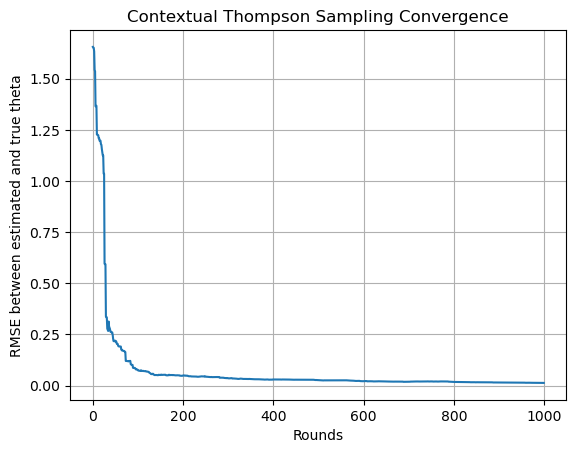

Estimated theta: [array([ 0.49437449, -0.1433398 ,  0.63990296,  1.51298855, -0.23401114]), array([-0.23807282,  1.58349023,  0.76676738, -0.46218883,  0.52910475]), array([-0.4629766 , -0.46831714,  0.23777525, -1.90959017, -1.72609789])]
True theta: [array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337]), array([-0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004]), array([-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783])]


In [3]:
# 参数设置
np.random.seed(42)
n_arms = 3
n_features = 5
true_thetas = [np.random.randn(n_features) for _ in range(n_arms)]  # 真正的θ

agent = ContextualThompsonSampling(n_arms=n_arms, n_features=n_features, v=0.1)

n_rounds = 1000
errors = []

for t in range(n_rounds):
    context = np.random.randn(n_features)
    rewards = [np.dot(theta, context) + np.random.randn() * 0.1 for theta in true_thetas]
    chosen_arm = agent.select_arm(context)
    agent.update(chosen_arm, context, rewards[chosen_arm])

    # 计算估计误差（均方根误差）
    est_thetas = agent.get_posterior_means()
    rmse = np.sqrt(np.mean([np.linalg.norm(est - true)**2 for est, true in zip(est_thetas, true_thetas)]))
    errors.append(rmse)

# 绘制估计误差随时间的变化
plt.plot(errors)
plt.xlabel("Rounds")
plt.ylabel("RMSE between estimated and true theta")
plt.title("Contextual Thompson Sampling Convergence")
plt.grid(True)
plt.show()

# 打印最终学到的θ
print("Estimated theta:", agent.get_posterior_means())
print("True theta:", true_thetas)